# Hybrid Genetic Algorithms: Seeding the population
***

In a previous notebook, we used Genetic Algorithms (GA) to find solutions to the Travelling Salesman Problem. GA are based on the Darwinian concept of natural selection and can be used to solve search and optimisation problems. [genoa](https://github.com/cdragun/genoa) is a GA package written in Python.

We worked with 3 datasets from the [University of Waterloo](http://www.math.uwaterloo.ca/tsp/index.html) 

| Dataset  | Region         | Num. Cities | Optimal tour | Possible routes |
|----------|---------------:|------------:|-------------:|----------------:|
| wi29.tsp | Western Sahara | 29          | 27,603       | 3.0e+29         |
| qa194.tsp| Qatar          | 194         | 9,352        | 6.9e+358        |
| uy734.tsp| Uruguay        | 734         | 79,114       | 4.0e+1783       |

While _genoa_ could solve the first problem and come close to the optimal solution for the second, it struggled with the third dataset after 8,000 generations.

A _hybrid strategy_ could use the sub-optimal solutions from a GA as a starting point for other algorithms. Vice-versa, it is possible to use other algorithms to seed the initial population in genoa - which is the focus of this experiment.

---
Author: Chandranath Gunjal, 2018

---


In [1]:
%matplotlib inline

import random
import re
import statistics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('white')

As before we store each city as a Point and define a few functions

In [2]:
class Point(complex):
    """2-D point"""
    x = property(lambda self: self.real)
    y = property(lambda self: self.imag)

    def __repr__(self):
        return 'Point({}, {})'.format(self.x, self.y)

    def __iter__(self):
        yield self.x
        yield self.y

def distance(a, b):
    """Return the distance between two points (rounded as per TSP datafile)"""
    return int(abs(a - b) + 0.5)

def load_tsp_data(filename):
    """Load tsp datafile and return a list of points"""
    pts = []
    tag_found = False

    with open(filename, "r") as fh:
        for line in fh:
            if re.match('EOF', line):
                break

            if re.match('EDGE_WEIGHT_TYPE', line):
                _, t = line.strip().split(': ')
                if t != 'EUC_2D':
                    raise TypeError('TSP format not supported: {}'.format(t))
                continue

            if re.match('NODE_COORD_SECTION', line):
                tag_found = True
                continue

            if not tag_found:
                continue

            # load the coordinates
            _, x, y = line.strip().split()
            pts.append(Point(float(x), float(y)))
    return pts

def tour_length(cities, tour):
    """Return the total length of a given tour"""
    return sum(distance(cities[tour[i - 1]], cities[tour[i]])
               for i in range(len(tour)))

def plot_lines(points, style='bo-'):
    """Plot lines to connect a series of points."""
    plt.plot([p.x for p in points], [p.y for p in points], style)
    # plt.axis('scaled'); plt.axis('off')
    plt.xticks([]); plt.yticks([]); # 

def plot_tour(cities, tour):
    """Plot the cities as circles and the tour as lines between them.
    Start city is a red square.
    """
    points = [cities[c] for c in tour]
    start = cities[tour[0]]
    plot_lines(points + [start])

    # Mark the start city with a red square
    plot_lines([start], 'rs')


## Fuzzy Nearest Neighbour Algorithm

The Nearest Neighbour algorithm is a greedy algorithm which picks the nearest unvisited city as the next destination in the tour. Given different starting points, the algorithm will result in slightly different tours - all of which are most likely to be sub-optimal.

The below routine is a variant on the theme - it picks at random from a set of nearest neighbours. This is to add some diversity to the paths (and edge information); and consequently the genetic information during the GA optimisation.


In [3]:
def fuzzy_nn_tour(cities, start=0, factor=1.0):
    """Modified nearest neighbour algorithm - at each point, find the distance
    to the nearest neighbour but choose from a sample of neighbours which are
    within a given factor of that distance.
    
    Set factor to 1.0 to get the nearest neighbour tour (caveat: unless there
    are two equidistant neighbours)
    """
    tour = [start]
    remaining = set(range(len(cities)))
    remaining.remove(start)

    while remaining:
        spans = [(distance(cities[c], cities[tour[-1]]), c) for c in remaining]
        
        threshold = min(spans)[0] * factor
        sample = [x for x in spans if x[0] <= threshold]
        nxt = random.choice(sample)[1]

        tour.append(nxt)
        remaining.remove(nxt)
        
    return tour

Load the TSP datasets and plot a few tours using the Fuzzy NN algorithm

In [4]:
# Load the datasets
wi29  = load_tsp_data('wi29.tsp')
qa194 = load_tsp_data('qa194.tsp')
uy734 = load_tsp_data('uy734.tsp')

def sample_tours(name, cities, start=0, factor=1.0):
    """Generate and plot two sample tours - the first as the original NN tour
    and the second a fuzzy tour with the given factor
    """
    t1 = fuzzy_nn_tour(cities, start, factor=1.0)
    t2 = fuzzy_nn_tour(cities, start, factor)

    # Plot these these two tours
    plt.figure(1, figsize=(18, 9))
    plt.subplot(121); plt.title('{}: Start {}, Length = {}'.
                                format(name, start, tour_length(cities, t1)))
    plot_tour(cities, t1)
    plt.subplot(122); plt.title('{}: Start {}, Length = {}'.
                                format(name, start, tour_length(cities, t2)))
    plot_tour(cities, t2)
    plt.show()

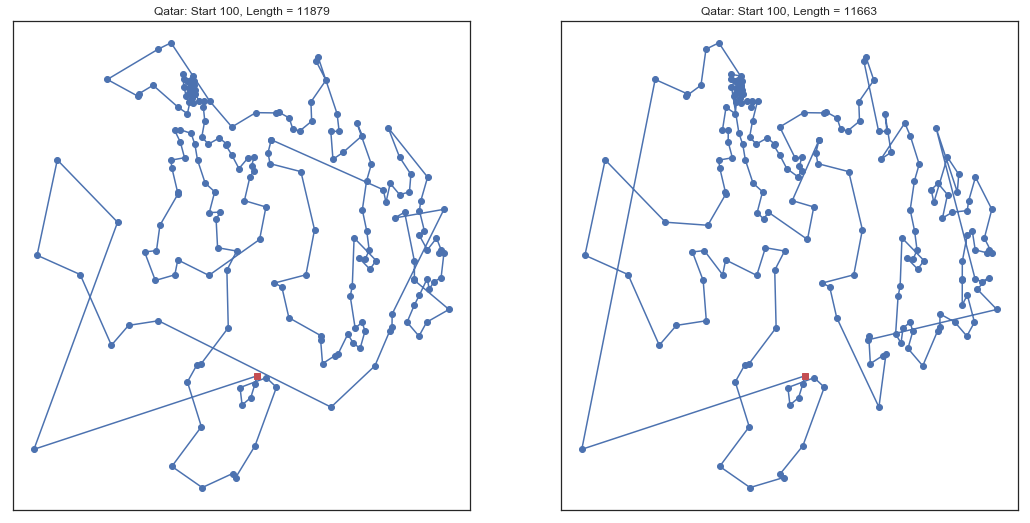

In [5]:
# Generate some test Fuzzy_NN tours on the Qatari set
sample_tours('Qatar', qa194, 100, 1.2)

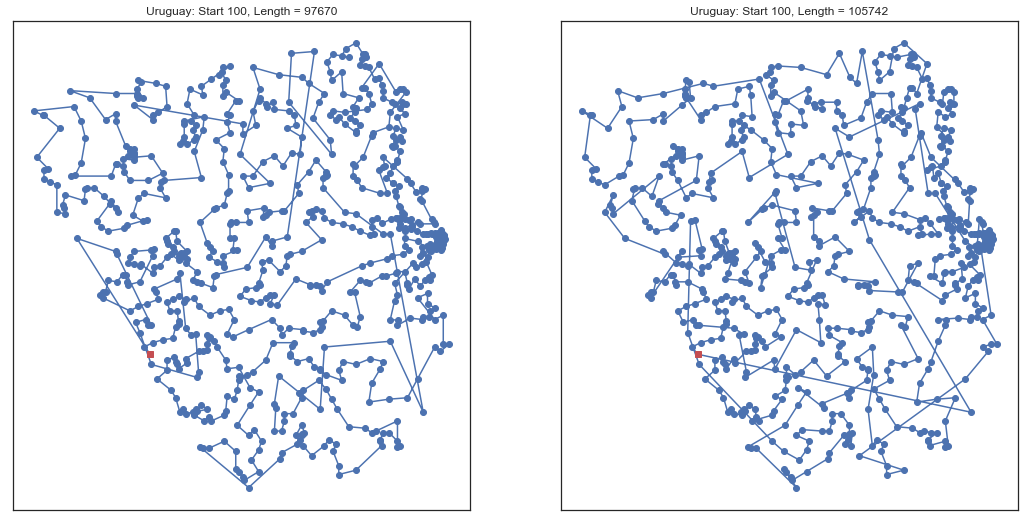

In [6]:
# And some on the Uruguayan set
sample_tours('Uruguay', uy734, 100, 1.2)

## Creating the seed population in genoa

In the TSP problem (see tsp.py), the GA assumes that the solution always starts at the last node (reducing the complexity of the problem slightly).

The following functions use the nearest neighbour algorithm to create a set of tours, which are then saved down as Individuals to seed the initial GA population. 

In [7]:
from individual import OrderedIndividual

def rotate_tour(tour):
    """Rotate a given tour to start at the final city."""
    i = tour.index(max(tour))
    return tour[i:] + tour[:i]

def generate_nntours(cities, howmany, factor):
    """Generate given number of tours starting from random cities."""
    return list(rotate_tour(fuzzy_nn_tour(cities, s, factor))
                for s in random.sample(range(len(cities)), howmany))

def create_seed_population(cities, howmany, factor):
    """Create a seed file with tours generated by the nearest-neighbour algorithm."""
    attr = OrderedIndividual.get_attributes()
    attr['osi.num_genes'] = len(cities) - 1

    # create a population of genoa individuals
    pop = [OrderedIndividual(attr) for _ in range(howmany)]
    
    # Replace the genes with the truncated tour (in the GA, the tour always
    # starts from the final city)
    for i, t in zip(pop, generate_nntours(cities, howmany, factor)):
        i.genes = t[1:]
    return pop


In [8]:
# Generate seed populations and save them (commented out for now) to a file.

#wi_seeds = create_seed_population(wi29, int(0.3 * len(wi29)), 1.2)
#OrderedIndividual.save_population('seed_wi.txt', wi_seeds)

#qa_seeds = create_seed_population(qa194, int(0.3 * len(qa194)), 1.2)
#OrderedIndividual.save_population('seed_qa.txt', qa_seeds)

#uy_seeds = create_seed_population(uy734, int(0.3 * len(uy734)), 1.2)
#OrderedIndividual.save_population('seed_uy.txt', uy_seeds)


## The hybrid experiment

The experiment is to generate Fuzzy NN tours by taking a random 30% of the cities as starting points. These will be converted to the genes of the OrderedIndividual and saved down in a file which is read by _genoa_ to seed the initial population.

Here are the results from the hybrid runs run over 9,000 generations (500 individuals with 25% replacement rate):

| Dataset  | Optimal tour |  Previous best | Hybrid Intial  | Hybrid Final| Improvement |
|:---------|-------------:|---------------:|---------------:|------------:|-------------|
| qa194.tsp| 9,352        | 9,962          | 11,635         | 9,945       | 0.2%        |
| uy734.tsp| 79,114       | 162,349        | 86,967         | 85,656      | 1.7%        |

The improvement (%change in Hybrid Best vs Previous Best) is only marginal and the GA does struggle in getting close to the optimal solution.

Below are the progress charts for these runs (mind that the y-axis scales differ).


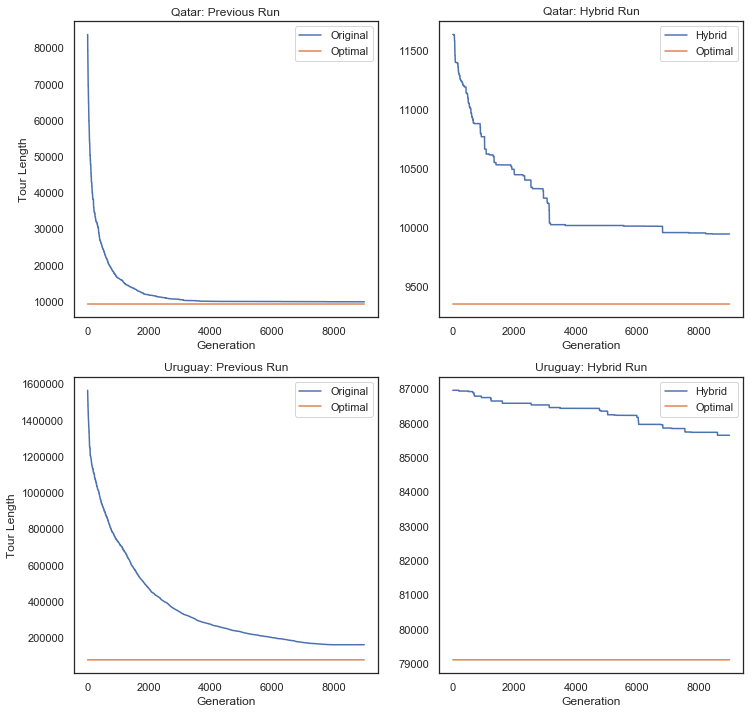

In [9]:
qa_progress = pd.read_csv('./results/qa194_p2.csv')
uy_progress = pd.read_csv('./results/uy734_p2.csv')

fig = plt.figure(figsize=(12,12))

qa_progress.plot(ax=plt.subplot(221, ylabel='Tour Length'), title='Qatar: Previous Run',
                 x='Generation', y=[1,3])
qa_progress.plot(ax=plt.subplot(222), title='Qatar: Hybrid Run',
                 x='Generation', y=[2,3])
uy_progress.plot(ax=plt.subplot(223, ylabel='Tour Length'), title='Uruguay: Previous Run',
                 x='Generation', y=[1,3])
uy_progress.plot(ax=plt.subplot(224), title='Uruguay: Hybrid Run',
                 x='Generation', y=[2,3])
plt.show()


## Some obervations

The NN algorithm generates some optimal sections in each tour - but being greedy, skips a few cities across the problem space. At the end it has to visit these cities (which results in the overall sub-optimal solution). These are the long trips that criss-cross the map.

The GA does a pretty good job in removing these sub-optimal (low-hanging?) trips - see tours below - but fails in re-organising the smaller sections to reach the optimal solution. The Position Mutator operation would definitely help, but overall the GA struggles with datesets containing more than 200 cities.


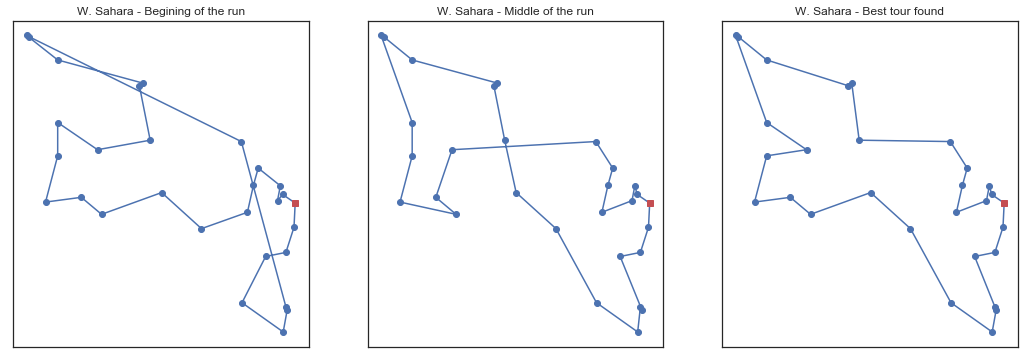

In [10]:
# The Western Sahara dataset
wi_t1="""
  28 22  20  21  18  17  16  13  12   8   6   2   3   4   7  11   9  10   5   0   1
  14  24  26  23  15  19  25  27"""

wi_t2="""
  28 27  25  19  26  24  23  15  13  12  11   9  10   5   1   0   4   3   2   8   6
   7  14  18  17  16  20  21  22"""

wi_t3="""
  28 27  25  19  24  26  23  15  13  12   8   6   2   3   7   4   0   1   5   9  10
  11  14  18  17  16  20  21  22"""

wi_tour1 = list(int(i) for i in wi_t1.split())
wi_tour2 = list(int(i) for i in wi_t2.split())
wi_tour3 = list(int(i) for i in wi_t3.split())

plt.figure(1, figsize=(18, 6));
plt.subplot(131); plot_tour(wi29, wi_tour1); plt.title('W. Sahara - Begining of the run')
plt.subplot(132); plot_tour(wi29, wi_tour2); plt.title('W. Sahara - Middle of the run')
plt.subplot(133); plot_tour(wi29, wi_tour3); plt.title('W. Sahara - Best tour found')
plt.show()

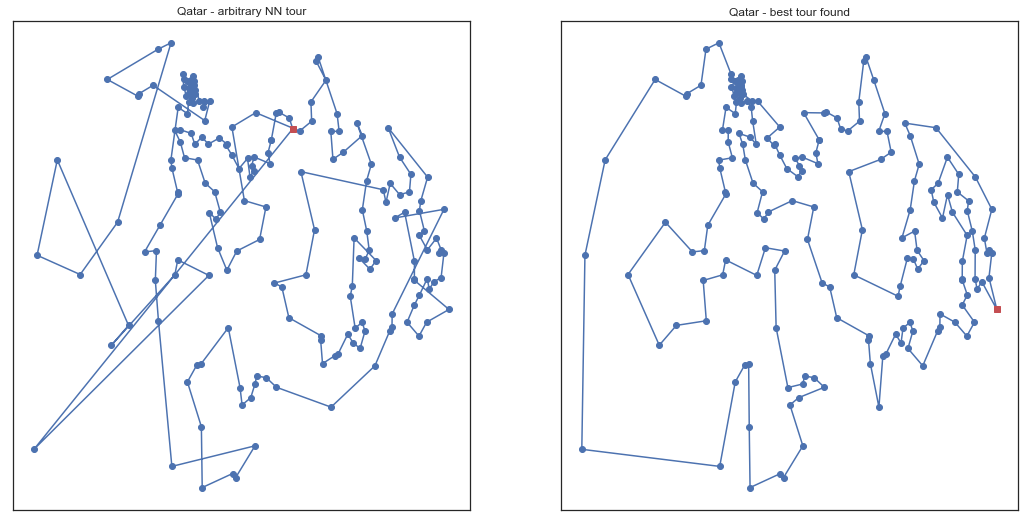

In [11]:
# the best Qatar tour found
qa_best = """
193  189 191 190 188 187 192 184 159 142 147 154 150 146 140 151 152 156 153 149 143
 138 137 118 121 117 130 135 134 128 132 127 123 122 119 120 116 115 114 111 109
  99 107 106 104 105  96  91  94  95  92  87  82  80  78  76  83  72  66  57  55
  52  51  53  54  48  49  41  43  47  45  40  37  42  39  33  30  34  31  29  18
  14  11   9   8   4   2   1   0  19  35  58  61  62  64  84  85  97  89  93 110
 103 100  98  88  81  79  86  75  70  24  22  12  15   7   5   3   6  10  13  16
  25  23  20  17  32  27  28  21  26  36  38  46  50  60  65  67  69  63  44  56
  59  68  73  71  74  77  90 102 101 108 112 113 125 124 126 129 131 133 136 139
 141 145 148 144 155 160 162 163 168 175 181 171 178 173 172 174 176 167 166 164
 158 157 161 165 170 169 179 177 180 183 182 185 186"""
qa_tour1 = list(int(i) for i in qa_best.split())

qa_nn = fuzzy_nn_tour(qa194, 115, 1.0)

plt.figure(1, figsize=(18, 9));
plt.subplot(121); plot_tour(qa194, qa_nn); plt.title('Qatar - arbitrary NN tour')
plt.subplot(122); plot_tour(qa194, qa_tour1); plt.title('Qatar - best tour found')
plt.show()

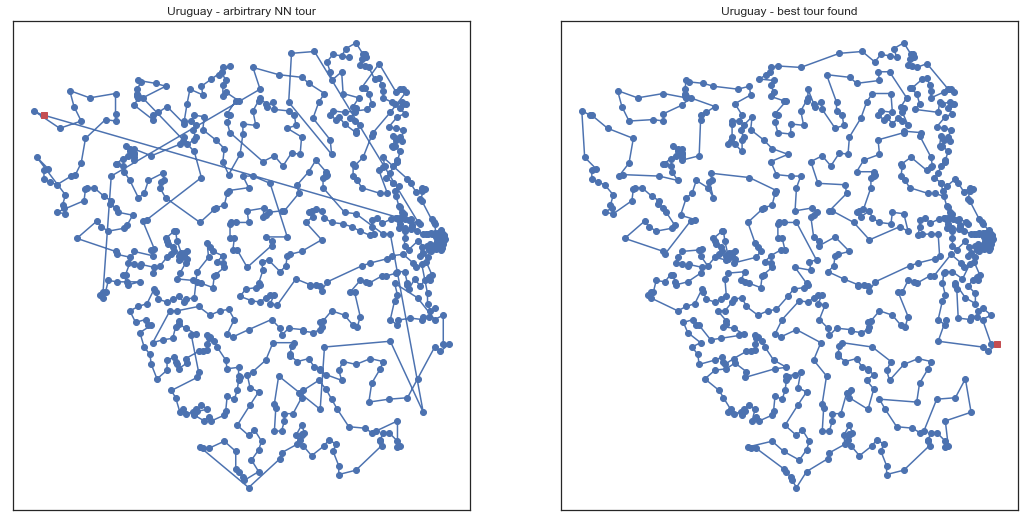

In [12]:
# the best Uruguay tour found
uy_best = """
 733 711 691 567 602 595 568 581 596 582 586 597 625 647 661 648 646 619 560 549 524
 520 505 490 483 504 501 486 476 456 436 430 432 429 416 404 405 372 362 358 343
 354 340 350 341 333 322 309 275 259 272 303 346 332 355 349 353 348 361 365 366
 381 390 393 403 398 426 443 424 444 427 428 419 408 388 375 376 379 382 440 473
 468 470 495 527 553 546 531 523 455 465 481 515 530 539 565 633 651 666 594 607
 592 593 564 552 545 544 548 494 466 467 460 463 451 439 414 402 392 395 396 406
 397 384 387 360 357 317 301 296 292 284 277 220 209 203 248 278 308 318 326 314
 302 281 306 319 307 310 298 286 289 285 282 274 257 253 249 227 221 213 215 205
 192 196 187 184 171 157 163 143 135 115 127 151 176 200 197 258 287 254 237 231
 224 218 222 217 216 210 201 172 147 144 140 128 101 100  93 105  86  77  95  98
 102 121 137 182 193 173 145 152 153 134 148 165 174 188 202 225 240 263 290 297
 315 323 320 299 328 327 338 304 279 271 267 266 276 283 273 243 238 242 250 234
 232 229 206 198 185 199 158 149 154 138 129 116 113 110  96  81  63  31  29  32
  34  36  47  51  56  58  60  87 106 111  89  88  69  61  64  70 103 112 107 118
 130 155 159 156 136 141 139 133 131 124 142 146 150 160 162 167 178 166 177 175
 223 230 226 219 204 233 235 251 260 264 207 122 123 120 125 119  99  94  82  68
  97  91  48  41  19  28  30  37  54  59  50  42  38  39  33  27  25  23  22  13
   8  12  11  14   9   7   3   4   6   1   0   2   5  10  24  20  16  18  40  65
  55  52  49  43  53  62  66  57  67  75  74  73  72  71 104 108 109 117 132  92
  76  45  44  35  21  17  15  26  46  83  84  78  79  80  85  90 114 126 181 208
 212 180 191 183 170 169 168 164 161 179 189 190 194 186 195 214 211 236 252 291
 244 265 293 311 305 300 331 339 335 329 334 345 344 370 399 377 369 368 359 385
 413 412 422 431 433 449 509 528 562 573 569 554 537 529 532 533 540 551 572 591
 598 605 630 639 642 654 657 645 644 643 650 665 671 677 684 687 701 713 716 725
 726 731 732 728 727 729 730 718 717 712 709 700 694 695 704 703 707 708 719 720
 714 696 690 686 662 658 663 670 664 649 641 636 606 585 576 580 561 570 577 599
 600 610 583 578 574 579 588 616 611 620 589 566 601 629 612 631 621 617 584 575
 571 522 535 525 511 516 538 542 550 558 557 590 632 622 613 543 526 517 508 512
 518 521 519 514 500 480 482 472 462 448 420 378 313 270 247 241 239 228 256 246
 255 245 280 288 262 269 261 268 294 295 316 312 321 324 325 336 337 347 352 371
 386 383 373 374 356 401 411 459 454 471 503 489 499 493 507 492 484 478 469 464
 453 461 479 475 442 425 418 400 394 380 364 351 330 342 389 391 363 367 407 434
 485 506 496 477 474 457 441 435 417 409 415 421 437 438 447 450 445 446 410 423
 458 452 497 498 536 534 556 559 555 541 513 488 491 487 502 510 547 563 587 603
 609 615 623 618 614 608 604 628 627 626 624 637 653 659 673 681 697 699 702 706
 705 724 721 715 710 698 689 685 680 668 656 676 672 688 679 683 669 655 675 674
 652 635 634 638 640 660 667 678 682 693 723 692 722"""
uy_tour1 = list(int(i) for i in uy_best.split())

uy_nn = fuzzy_nn_tour(uy734, 5, 1.0)

plt.figure(1, figsize=(18, 9));
plt.subplot(121); plot_tour(uy734, uy_nn); plt.title('Uruguay - arbirtrary NN tour')
plt.subplot(122); plot_tour(uy734, uy_tour1); plt.title('Uruguay - best tour found')
plt.show()